## Importing necessary libraries

In [208]:
!pip install joblib

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pywt
import tensorflow.keras as keras
import joblib
import json
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Fetch list of cropped images

In [16]:
path_to_cr_data = "./dataset_cropped/"
cropped_image_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        cropped_image_dirs.append(entry.path)

In [18]:
crics_file_names_dict={}
for crp_img_dir in cropped_image_dirs:
    crics_name = crp_img_dir.split('/')[-1]
    crics_file_names_dict[crics_name] = []
    for entry in os.scandir(crp_img_dir):
        crp_file = entry.path.replace("\\","/")
        crics_file_names_dict[crics_name].append(crp_file)

In [19]:
crics_file_names_dict

{'ab_devilliers': ['./dataset_cropped/ab_devilliers/ab_devilliers1.png',
  './dataset_cropped/ab_devilliers/ab_devilliers10.png',
  './dataset_cropped/ab_devilliers/ab_devilliers100.png',
  './dataset_cropped/ab_devilliers/ab_devilliers103.png',
  './dataset_cropped/ab_devilliers/ab_devilliers107.png',
  './dataset_cropped/ab_devilliers/ab_devilliers108.png',
  './dataset_cropped/ab_devilliers/ab_devilliers109.png',
  './dataset_cropped/ab_devilliers/ab_devilliers11.png',
  './dataset_cropped/ab_devilliers/ab_devilliers111.png',
  './dataset_cropped/ab_devilliers/ab_devilliers113.png',
  './dataset_cropped/ab_devilliers/ab_devilliers114.png',
  './dataset_cropped/ab_devilliers/ab_devilliers115.png',
  './dataset_cropped/ab_devilliers/ab_devilliers116.png',
  './dataset_cropped/ab_devilliers/ab_devilliers117.png',
  './dataset_cropped/ab_devilliers/ab_devilliers12.png',
  './dataset_cropped/ab_devilliers/ab_devilliers121.png',
  './dataset_cropped/ab_devilliers/ab_devilliers122.png',
  

In [20]:
for cricketer, images in crics_file_names_dict.items():
    print(cricketer, len([item for item in images]))

ab_devilliers 110
brendon_mccullum 75
chris_gayle 40
dale_steyn 103
hardik_pandya 161
james_anderson 92
ms_dhoni 146
muttiah_muralitharan 106
pat_cummins 176
rashid_khan 150
ravi_ashwin 163
umran_malik 134


## Create wavelet transformed images

In [21]:
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)/255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H = np.uint8(imArray_H*255)
    return imArray_H

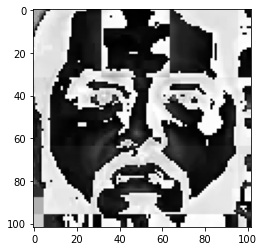

In [30]:
im_har = w2d(crpd[0],'db1',5)
plt.imshow(im_har,cmap='gray')

# Target class encoding

In [31]:
class_dict={}
count=0
for cricketer in crics_file_names_dict.keys():
    class_dict[cricketer] = count
    count += 1
class_dict    

{'ab_devilliers': 0,
 'brendon_mccullum': 1,
 'chris_gayle': 2,
 'dale_steyn': 3,
 'hardik_pandya': 4,
 'james_anderson': 5,
 'ms_dhoni': 6,
 'muttiah_muralitharan': 7,
 'pat_cummins': 8,
 'rashid_khan': 9,
 'ravi_ashwin': 10,
 'umran_malik': 11}

## Create input and output data for the image classification

In [63]:
X=[]
y=[]

for cricketer, images in crics_file_names_dict.items():
    for image in images:
        img = cv2.imread(image)
        scl_raw = cv2.resize(img,(32,32))
        img_wt = w2d(img,'db1',5)
        scl_img_wt = cv2.resize(img_wt,(32,32))
        combined_img = np.vstack((scl_raw.reshape(32*32*3,1),scl_img_wt.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[cricketer])
        
X = np.array(X).reshape(len(X),4096).astype(float)

In [64]:
X.shape

(1456, 4096)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.717032967032967

In [37]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test,y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        26
           1       0.56      0.38      0.45        13
           2       0.83      0.50      0.62        10
           3       0.71      0.63      0.67        27
           4       0.82      0.82      0.82        45
           5       0.68      0.68      0.68        22
           6       0.66      0.62      0.64        40
           7       0.58      0.78      0.67        18
           8       0.60      0.83      0.70        42
           9       0.93      0.74      0.82        53
          10       0.67      0.72      0.69        39
          11       0.92      0.83      0.87        29

    accuracy                           0.72       364
   macro avg       0.71      0.68      0.69       364
weighted avg       0.73      0.72      0.72       364



In [66]:
len(X_test)

364

<AxesSubplot:>

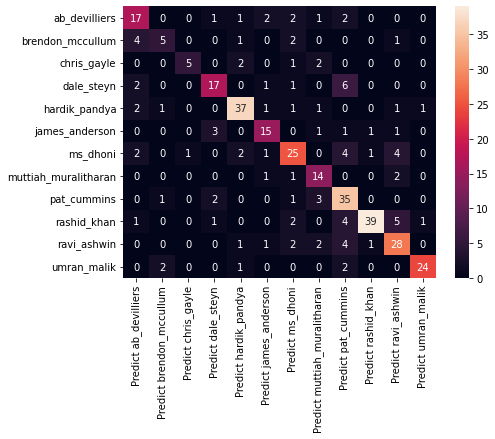

In [39]:
cm=confusion_matrix(y_test, y_pred, labels=list(np.arange(12)))
df_cm = pd.DataFrame(cm, index = list(crics_file_names_dict.keys()), columns = ["{}{}".format("Predict ",i) for i in list(crics_file_names_dict.keys())])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g')

In [81]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [5,10,100,1000],
            'randomforestclassifier__max_features': ['sqrt','log2']
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000),
        'params': {
            'logisticregression__C': [0.01,0.1,1,5,10],
            'logisticregression__multi_class': ['auto','multinomial'],
        }
    },
    'sgd': {
        'model': SGDClassifier(max_iter=1000, eta0=1.0),
        'params': {
            'sgdclassifier__loss': ['hinge','log_loss','modified_huber'],
            'sgdclassifier__alpha': [1e-1, 1e-2, 1e-3, 1e-4],
            'sgdclassifier__learning_rate': ['optimal','adaptive'],
            'sgdclassifier__penalty': ['l1','l2']
        }
    }
}

In [82]:
scores=[]
best_estimators={}
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False,error_score='raise')
    clf.fit(X_train,y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_

,model,best_score,best_params
0,svm,0.749948,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.601634,{'randomforestclassifier__max_features': 'sqrt...
2,logistic_regression,0.757300,"{'logisticregression__C': 1, 'logisticregressi..."
3,sgd,0.706916,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie..."


In [83]:
best_estimators['svm'].score(X_test,y_test)

0.7802197802197802

In [88]:
best_estimators['random_forest'].score(X_test,y_test)

0.6538461538461539

In [85]:
best_estimators['sgd'].score(X_test,y_test)

0.7692307692307693

In [86]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7994505494505495

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
print(X_train.shape)
print(X_test.shape)

(1092, 4096)
(364, 4096)


In [230]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=12)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=12)

In [231]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [236]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(128,input_shape=(4096,)))
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(12,input_shape=(128,)))
model.add(keras.layers.Dense(12,activation = 'softmax'))

In [237]:
sgd_opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [238]:
model.fit(X_train,y_train_cat,epochs=20,validation_data=(X_test,y_test_cat),batch_size=500,verbose=0)

_, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
_, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.077, Test: 0.071


In [239]:
X_train[0]

array([ 37.,  34.,  30., ..., 254.,   0., 255.])

In [240]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(128,input_shape=(4096,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(12,input_shape=(128,)))
model.add(keras.layers.Dense(12,activation = 'softmax'))

In [241]:
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train_cat,epochs=20,validation_data=(X_test,y_test_cat),batch_size=500,verbose=0)

_, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
_, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.829, Test: 0.495


In [242]:
adam_opt = keras.optimizers.Adam(learning_rate=0.1,decay=0.001)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train_cat,epochs=20,validation_data=(X_test,y_test_cat),batch_size=500,verbose=0)

_, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
_, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.225, Test: 0.203


In [243]:
def train_and_test(iteration,batch,lrate,decay):
    keras.backend.clear_session()   #To clear the blackboard and start building the network again

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128,input_shape=(4096,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(12,input_shape=(128,)))
    model.add(keras.layers.Dense(12,activation = 'softmax'))

    adam_opt = keras.optimizers.Adam(learning_rate=lrate,decay=decay)
    model.compile(optimizer=adam_opt,loss='categorical_crossentropy',metrics=['accuracy'])

    model.fit(X_train,y_train_cat,epochs=iteration,validation_data=(X_test,y_test_cat),batch_size=batch,verbose=0)

    _, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    return train_acc

In [244]:
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-1, -3))
    decay = math.pow(10, np.random.uniform(-1, -4))
    best_acc = train_and_test(10, 500, lr, decay) #just 10 epochs
    print("Run: {0}, Best_acc: {1}, lr: {2}, decay: {3}\n".format(k, best_acc, lr, decay))

Run: 1, Best_acc: 0.3910256326198578, lr: 0.001385949054025749, decay: 0.0012075516063343441

Run: 2, Best_acc: 0.7765567898750305, lr: 0.0010643238512167117, decay: 0.0007811341472820607

Run: 3, Best_acc: 0.5027472376823425, lr: 0.0253463934937256, decay: 0.00032762180989898967

Run: 4, Best_acc: 0.6520146727561951, lr: 0.0011202564210727314, decay: 0.0755426117410178

Run: 5, Best_acc: 0.6950549483299255, lr: 0.003006992526639206, decay: 0.028380293139611244

Run: 6, Best_acc: 0.4413919448852539, lr: 0.004537372962930797, decay: 0.03726599177067287

Run: 7, Best_acc: 0.25, lr: 0.02160911983171451, decay: 0.03605955061128783

Run: 8, Best_acc: 0.39652013778686523, lr: 0.04816713501752813, decay: 0.00018795883995261916

Run: 9, Best_acc: 0.5, lr: 0.015771025217519954, decay: 0.0784180084554123



In [256]:
keras.backend.clear_session()   #To clear the blackboard and start building the network again

model = keras.models.Sequential()
model.add(keras.layers.Dense(1024,input_shape=(4096,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dense(256,input_shape=(1024,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(12,input_shape=(256,)))
model.add(keras.layers.Dense(12,activation = 'softmax'))

adam_opt = keras.optimizers.Adam(learning_rate=0.001,decay=0.0007)
model.compile(optimizer=adam_opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train_cat,epochs=200,validation_data=(X_test,y_test_cat),batch_size=500,verbose=0)

_, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
_, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.995, Test: 0.692


<AxesSubplot:>

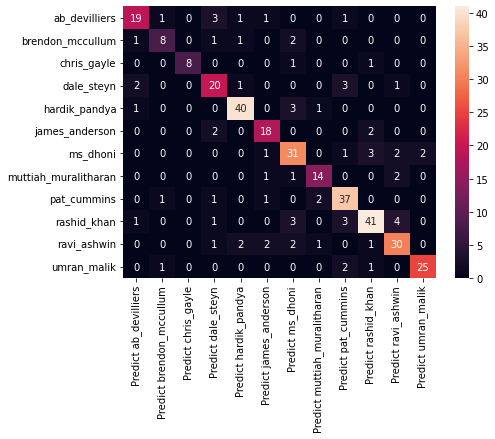

In [99]:
best_clf = best_estimators['logistic_regression']
y_pred = best_clf.predict(X_test)
cm=confusion_matrix(y_test, y_pred, labels=list(np.arange(12)))
df_cm = pd.DataFrame(cm, index = list(crics_file_names_dict.keys()), columns = ["{}{}".format("Predict ",i) for i in list(crics_file_names_dict.keys())])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g')

In [100]:
def get_cropped_image_if_2_eyes(image_path):
    faces_list=[]
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0:
        for i in range(faces.shape[0]):
            (x,y,w,h) = faces[i]
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                faces_list.append(roi_color)
        return faces_list
    else:
        print('No recognizable face')

In [220]:
def pred_image(image_path):
    roi_color = np.array(get_cropped_image_if_2_eyes(image_path))
    try:      
        for i in np.arange(roi_color.shape[0]):
            img = roi_color[i]
            scl_raw = cv2.resize(img,(32,32))
            img_wt = w2d(img,'db1',5)
            scl_img_wt = cv2.resize(img_wt,(32,32))
            combined_img = np.vstack((scl_raw.reshape(32*32*3,1),scl_img_wt.reshape(32*32,1)))
            X_test1 = combined_img.reshape(1,4096).astype(float)
            print({i for i in class_dict if class_dict[i]==best_clf.predict(X_test1)[0]})
    except:
        print('image prediction failed')

In [224]:
path_to_test_data = "./test_images/"
for entry in os.scandir(path_to_test_data):
    print(entry.path)
    pred_image(entry.path)

./test_images/15 Cricketers And Their Hottest Wives.jpg
{'ab_devilliers'}
./test_images/320500.webp
{'rashid_khan'}
./test_images/Achievements of _Thala_ on ODI_ Test.jpg
{'james_anderson'}
./test_images/Ashes 2021_ James Anderson cites Team.webp
./test_images/Ashes_ Australian captain Pat Cummins.jpg
{'pat_cummins'}
./test_images/Australia in Cape Town.jpg
{'dale_steyn'}
./test_images/Australia_s Pat Cummins ruled out until.jpg
No recognizable face
image prediction failed
./test_images/Balloonistics Mahendra Singh Dhoni.jpeg
No recognizable face
image prediction failed
./test_images/being punished for not using DRS.jpg
{'ms_dhoni'}
./test_images/biography_ records_ IPL success.jpg
No recognizable face
image prediction failed
./test_images/Bowlers like Umran Malik have factories.jpg
{'umran_malik'}
./test_images/Chris Gayle goes overboard on Pakistan.jpg
{'rashid_khan'}
./test_images/Chris Gayle Instagram_ Cricketer leaves.png
No recognizable face
image prediction failed
./test_images/

C:\Users\DELL\AppData\Local\Temp/ipykernel_2016/3411579073.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  roi_color = np.array(get_cropped_image_if_2_eyes(image_path))


## Save trained model

In [257]:
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

## Save class dictionary

In [260]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))